In [1]:
import sys
sys.path.append('../')

import controller
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MODE = 3
MODE_DICT = {0: "Training Neural Model", 1: "Demonstrate Neural Model", 
             2: "Demonstrate Simple Equation", 3: "Test Neural Model",
             4: "Test Simple Equation"}
print(MODE_DICT[MODE])

Test Neural Model


In [3]:
CAR_MODEL = "complex"
ci = controller.Car_Interface(model = CAR_MODEL)

ci.set_gear(ci.FORWARD)

In [4]:
np.random.seed(181)

# Accelerates the given car interface until it arrives at the target velocity
def accelerate_until_velocity(ci, target_vel):
    while(len(ci.log["velocity"]) == 0 or ci.log["velocity"][-1] < target_vel):
        ci.apply_control(pedal = ci.ACCELERATOR, amount = 1.0)

'''
Accelerate until a randomly determined target velocity.
Record the actual achieved velocity (which maybe a little higher)
Then brake for enough time, so that we know we've stopped.
The stopping distance is then the difference in the car's position
now and when we started braking.
'''
def stopping_distance_gen(ci, t = 50):
    amt = 0.15 + random.random() * 0.85
    initial_velocity = random.random()

    accelerate_until_velocity(ci, initial_velocity)
    initial_velocity = ci.log["velocity"][-1]
    ci.zero_position()
    ci.apply_control_for_time(pedal = ci.BRAKE, amount = amt, time = t)

    stopping_distance = ci.log["position"][-1]
    inp = [initial_velocity, stopping_distance]

    return amt, inp

In [5]:
amt, (initial_velocity, stopping_distance) = stopping_distance_gen(ci)
print(f"A car moving at {initial_velocity * 100:.2f}% speed, applied {amt * 100:.2f}% brakes and stopped, after travelling {stopping_distance:.2f} distance units")

A car moving at 96.60% speed, applied 44.68% brakes and stopped, after travelling 4.20 distance units


In [6]:
# Analytically solve for the theoretical stopping distance
def actual_stopping_distance(initial_velocity, amt):
    x = ci.brake_weight * amt + ci.rolling_bias
    f = ci.friction_constant
    v0 = initial_velocity
    
    if ((1-f*v0/x) < 0):
        return float("inf")
    
    d = ((x/f)*np.log(1-f*v0/x) + v0)/f
    return d

'''
Use binary search to approximate the required brake amount,
that results in a target stopping distance given an intial velocity.
'''
def approximate_amount(inp, tol = 1e-5, min_amt = 0, max_amt = 1):
    mid_amt = (min_amt + max_amt) / 2
    if (max_amt - min_amt < 2 * tol):
        return mid_amt

    v0, stopping_distance = inp
    if (actual_stopping_distance(v0, mid_amt) < stopping_distance):
        return approximate_amount(inp, tol, min_amt, mid_amt)
    else:
        return approximate_amount(inp, tol, mid_amt, max_amt)

In [7]:
if (MODE == 4):
    for i in range(3):
            amt, (initial_velocity, stopping_distance) = stopping_distance_gen(ci)
            pred = approximate_amount((initial_velocity, stopping_distance))
            print(f"Car moving at {initial_velocity * 100:.2f}%; Target Stopping Distance {stopping_distance:.2f} distance units")
            print(f"Simulation Brake Amount: {amt*100:.2f}%; Closed Form Brake Amount {pred*100:.2f}%")
            print()

In [8]:
# Fully Connected Network Class (a custom subclass of torch's nn module)
class fcn(nn.Module):

    def __init__(self):
        super().__init__()

        # Number of hidden units in first hidden layer
        self.H_1 = 30
        # Number of hidden units in second hidden layer
        self.H_2 = 20
        
        '''
        Weights generally [input dim, output dim] so when we multiply a vector
        of size [input dim] by a matrix of size [input dim, output dim] we get
        a vector of size [output dim].  The bias will have shape [output dim]
        so we can add it to the result of the weight-vector multiplication.
        '''
        
        #Weights and Biases for computing input -> first hidden layer
        self.W_1 = nn.Parameter(torch.randn([2, self.H_1]))
        self.B_1 = nn.Parameter(torch.randn([self.H_1]))

        #Weights and Biases for computing first -> second hidden layer
        self.W_2 = nn.Parameter(torch.randn([self.H_1, self.H_2]))
        self.B_2 = nn.Parameter(torch.randn([self.H_2]))
        
        #Weights and Biases for computing second hidden layer -> output
        self.W_3 = nn.Parameter(torch.randn([self.H_2, 1]))
        self.B_3 = nn.Parameter(torch.randn([1]))

    # Forward propogation
    def forward(self, x):
        
        # x will be a vector of length 2 containing the initial velocity and desired stopping distance
        x = torch.tensor(x, dtype = torch.float32)

        # first hidden layer computation with tanh activation
        h_1 = torch.tanh(torch.matmul(x, self.W_1) + self.B_1)
    
        # second hidden layer computation with tanh activation
        h_2 = torch.tanh(torch.matmul(h_1, self.W_2) + self.B_2)
        
        #output computation with no activation.  We technically get a vector of length 1 so we squeeze to get value.
        out = torch.squeeze(torch.matmul(h_2, self.W_3) + self.B_3)

        '''
        Our output is a scaled sigmoid (output range (0, 1.15)).  This helps model learn faster since all 
        desired outputs are in the range (0.15, 1).
        '''
        return 1.15 * torch.sigmoid(out)

In [9]:
#If demonstrating or testing just load initialize FCN with learned weights
if (MODE == 1 or MODE == 3):
    FN = "weights_" + CAR_MODEL

    model = fcn()
    model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

In [13]:
#Training (not we may start from previously learned weights)
if (MODE == 0):
    # Number of batches of data in a "epoch"
    NUM_BATCHES = 10
    # Number of data points in a single batch
    BATCH_SIZE = 30
    '''
    Number of epochs. Note generally an epoch is a pass through the whole dataset.  
    Here we are artifically generated data, so the size of an epoch is artificial as well.
    It will be (NUM_BATCHES * BATCH_SIZE).
    '''
    EPOCHS = 10

    # Do we want to use previously trained weights?
    USE_LAST = False

    FN = "weights_" + CAR_MODEL

    model = fcn()
    if(USE_LAST):
        model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

    '''
    Adam is an improved version of standard Stochastic Gradient Descent.
    The Stochastic refers to the fact that we update weights based on
    a small subset of our overall dataset, rather than computing the gradient
    over the entire dataset which can very time consuming.  Typically small
    batches represent the overall data patterns in the long run.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    for e in range(EPOCHS):
        # epoch loss
        e_loss = 0
        for b in range(NUM_BATCHES):
            # batch loss
            b_loss = 0
            for i in range(BATCH_SIZE):
                # Generate a data point
                amt, inp = stopping_distance_gen(ci)
                
                # Find the model's predicted brake amount
                out = model(inp)
                
                # Compute MSE between model output and actual
                amt_t = torch.tensor(amt)
                b_loss += (out - amt_t) ** 2

            b_loss /= BATCH_SIZE
            
            # Update weights
            optimizer.zero_grad()
            b_loss.backward()
            optimizer.step()

            b_loss = b_loss.detach().numpy()
            print(f"B {b} L {b_loss:.4f}", end = "\r")
            e_loss += b_loss

        e_loss /= NUM_BATCHES
        print(f"EPOCH {e + 1} {e_loss:.4f}")
        
        # save weights
        torch.save(model.state_dict(), open(FN + ".pt", "wb"))

In [11]:
# Demonstrate model's effectiveness on a few generated data points
if (MODE == 1 or MODE == 2):
    DEM = 5

    for i in range(DEM):

        amt, inp = stopping_distance_gen(ci)

        if (MODE == 1):
            out = model(inp).detach().numpy()
        elif (MODE == 2):
            out = approximate_amount(inp, tol = 1e-5)

        print(f"INIT VEL: {inp[0]:.3f} TARG SD: {inp[1]:.3f} BRK AMT: {amt:.3f} MODEL OUT:{out:.3f} ")

WITHIN 0.1 281/300 times
AVERAGE ERROR 0.03599084519608484


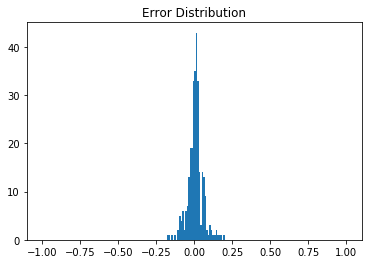

In [12]:
# Evaluate models over a larger set of datapoints, plot error distribution.
if (MODE == 3 or MODE == 4):
    TEST = 300
    correct = 0
    tol = 0.1
    errors = []
    for i in range(TEST):
        print(f"TESTING {i + 1}/{TEST}", end = "\r")
        amt, inp = stopping_distance_gen(ci)

        if (MODE == 3):
            out = model(inp).detach().numpy()
        elif (MODE == 4):
            out = approximate_amount(inp, tol = 1e-5)

        if (abs(out - amt) < tol):
            correct += 1
        errors.append(out - amt)
    print(f"WITHIN {tol} {correct}/{TEST} times")
    print(f"AVERAGE ERROR {np.mean(np.abs(errors))}")

    plt.title("Error Distribution")
    plt.hist(errors, bins = 200, range = (-1, 1))
    plt.show()